# Imports

In [1]:
import numpy as np
import cv2
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile
import json
import csv

from distutils.version import StrictVersion
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

from scipy.spatial import distance

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops

if StrictVersion(tf.__version__) < StrictVersion('1.9.0'):
    raise ImportError('Please upgrade your TensorFlow installation to v1.9.* or later!')


## Env setup

In [2]:
# This is needed to display the images.
%matplotlib inline

## Object detection imports


In [3]:
from utils import label_map_util
from utils import visualization_utils as vis_util

/home/angel/.virtualenvs/cv/lib/python3.5/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


# Helper Code

### load single image

In [4]:
def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)

### run inference over a single image

In [5]:
def run_inference_for_single_image(image, graph):
    with graph.as_default():
        with tf.Session() as sess:
            # Get handles to input and output tensors
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            
            for key in ['num_detections', 'detection_boxes', 'detection_scores','detection_classes', 'detection_masks']:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(tensor_name)
      
            if 'detection_masks' in tensor_dict:
                # The following processing is only for single image
                detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
                
                # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(detection_masks, detection_boxes, image.shape[0], image.shape[1])
                detection_masks_reframed = tf.cast(tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                
                # Follow the convention by adding back the batch dimension
                tensor_dict['detection_masks'] = tf.expand_dims(detection_masks_reframed, 0)
      
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

            # Run inference
            output_dict = sess.run(tensor_dict, feed_dict={image_tensor: np.expand_dims(image, 0)})

            # all outputs are float32 numpy arrays, so convert types as appropriate
            output_dict['num_detections'] = int(output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict['detection_classes'][0].astype(np.uint8)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
            
            if 'detection_masks' in output_dict:
                output_dict['detection_masks'] = output_dict['detection_masks'][0]
    
    return output_dict

### intersection over union

In [6]:
# https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/

def bb_intersection_over_union(boxA, boxB):
    """
        calculate IoU accuracy measure
    """
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])  # xmin
    yA = max(boxA[1], boxB[1])  # ymin
    xB = min(boxA[2], boxB[2])  # xmax
    yB = min(boxA[3], boxB[3])  # ymax

    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)

    # compute the area of both the prediction and ground-truth rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

    # compute the intersection over union by taking the intersection area and dividing it 
    # by the sum of prediction + ground-truth areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)

    # return the intersection over union value
    return iou

### image percentage occupacy 

In [7]:
def pannelPercentageOccupacy(totalPixels, pannelPixels):
    """
     ocuppation percentage of panel over all image(value between 0 and 1)   
    """
    return pannelPixels / totalPixels

### center of bounding box

In [8]:
def getCenterBox(box):
    """
        get center of bounding box define by (xmin,ymin,xmax,ymax)
    """
    x = box[2] - box[0]
    y = box[3] - box[1]
    
    return (x//2 + box[0], y//2 + box[1])  

### image groundtruth bounding boxes

In [9]:
def boundingBoxGroundTruth(jsonfilepath, filename):
    """
        get groundtruth panel boxes for filename image
    """
    annotations = json.load(open(jsonfilepath))
    for a in annotations.values():
        if(a['filename'] == filename):
            imageValues = a
            polygons = [r['shape_attributes'] for r in imageValues['regions'].values()]
            boxes = []
            for p in polygons:
                x_list, y_list = p['all_points_x'], p['all_points_y']
                ymin, xmin, ymax, xmax = min(y_list), min(x_list), max(y_list), max(x_list)
                boxes.append((xmin, ymin, xmax, ymax))
    
    return boxes

### graph with test images info

In [10]:
def groundTruthSizeGraph(jsonfilepath, csvfilepath):
    """
        create map with panels in groundtruth separates by panel size
    """
    count = [0,0,0,0,0,0,0]
    
    annotations = json.load(open(jsonfilepath))
    for a in annotations.values():
        img = cv2.imread(os.path.join('test_images',a['filename']))
        totalSize =  img.shape[0] * img.shape[1]
        
        polygons = [r['shape_attributes'] for r in a['regions'].values()]
        for p in polygons:
            x_list, y_list = p['all_points_x'], p['all_points_y']
            ymin, xmin, ymax, xmax = min(y_list), min(x_list), max(y_list), max(x_list)
            
            totalPanelSize = (ymax - ymin) * (xmax - xmin)
            percentage = pannelPercentageOccupacy(totalSize, totalPanelSize)
            
            # increment instance count
            if((percentage >= 0.0) and (percentage < 0.1)): count[0] += 1
            elif((percentage >= 0.1) and (percentage < 0.2)): count[1] += 1
            elif((percentage >= 0.2) and (percentage < 0.3)): count[2] += 1
            elif((percentage >= 0.3) and (percentage < 0.4)): count[3] += 1
            elif((percentage >= 0.4) and (percentage < 0.5)): count[4] += 1
            elif((percentage >= 0.5) and (percentage < 0.6)): count[5] += 1
            elif((percentage >= 0.6) and (percentage < 0.7)): count[6] += 1
            
    # create graph with matplotlib
    x = np.arange(len(count))
    
    fig, axs = plt.subplots()
    plt.bar(x, count)
    axs.set_ylim(0,80)
    plt.xticks(x, tuple([str(i)+"-"+str(i+10)+"%" for i in range(0,70,10)]))
    
    fig.suptitle('GroundTruth Test:  number of real panels clasified by panel Size', fontsize=16)
    axs.set_ylabel('nº panels')
    axs.set_xlabel('panel size')
    plt.show()
    
    # create csv report
    column_name = ['box size', 'nº boxes']
    csvfile = open(csvfilepath, 'w')
    writer = csv.writer(csvfile, delimiter=',', quotechar='|', quoting=csv.QUOTE_MINIMAL)
    writer.writerow(column_name)
    
    for idx, i in enumerate(range(0,70,10)):
        writer.writerow([str(i)+"-"+str(i+10)+"%", count[idx]])
        
    csvfile.close()

### nº images vs panel size graph and report

In [11]:
# precision for detections (if a image has not box prediction, this no appear in statistics)

def predictionsHistogram(predictionMap, csvfilepath):
    """
        create graph and csv report to show nº images for each precision value
    """
    # initial counts
    count = [0,0,0,0,0,0,0,0,0,0]
    
    # loop over image IoU
    for imageInfo in predictionMap.values():
        if len(imageInfo['boxes']) > 0:
            for pred in imageInfo['boxes'].values():
                iou = pred['IoU']
                
                # increment instance count
                if((iou >= 0.0) and (iou < 0.1)): count[0] += 1
                elif((iou >= 0.1) and (iou < 0.2)): count[1] += 1
                elif((iou >= 0.2) and (iou < 0.3)): count[2] += 1
                elif((iou >= 0.3) and (iou < 0.4)): count[3] += 1
                elif((iou >= 0.4) and (iou < 0.5)): count[4] += 1
                elif((iou >= 0.5) and (iou < 0.6)): count[5] += 1
                elif((iou >= 0.6) and (iou < 0.7)): count[6] += 1
                elif((iou >= 0.7) and (iou < 0.8)): count[7] += 1
                elif((iou >= 0.8) and (iou < 0.9)): count[8] += 1
                else: count[9] += 1
                
    # create graph with matplotlib    
    x = np.arange(len(count))
    
    fig, axs = plt.subplots()
    plt.bar(x, count)
    plt.xticks(x, tuple([str(i*10) + "-" + str((i+1)*10) + "%" for i in range(len(count))]), rotation=90)
    
    fig.suptitle('Precision of Detections boxes', fontsize=16)
    axs.set_ylabel('nº images')
    axs.set_xlabel('precision box')
    plt.show()
    
    # create csv report
    column_name = ['precision', 'nº boxes']
    csvfile = open(csvfilepath, 'w')
    writer = csv.writer(csvfile, delimiter=',', quotechar='|', quoting=csv.QUOTE_MINIMAL)
    writer.writerow(column_name)
    
    for i in range(len(count)):
        writer.writerow([str(i*10)+"-"+str((i+1)*10)+"%", count[i]])
        
    csvfile.close()

### nº detections vs panel size and precision mean vs panel size graphs and report

In [12]:
def percentagePanelSizeVsTotal(predictionMap, csvfilepath):
    """
      create graphs and csv report for detecctions:
          - nº detection vs panel size
          - precision mean vs panel size
    """
    # initials counts
    count = [0,0,0,0,0,0,0]
    meanArray = [[],[],[],[],[],[],[]]
        
    # loop over image IoU
    for imageInfo in predictionMap.values():
        if(len(imageInfo['boxes']) > 0):
            for pred in imageInfo['boxes'].values():
                size = pred['predictPanelSize']

                # increment instance count
                if((size >= 0.0) and (size < 0.1)):
                    meanArray[0].append(pred['IoU'])
                    count[0] += 1
                elif((size >= 0.1) and (size < 0.2)):
                    meanArray[1].append(pred['IoU'])
                    count[1] += 1
                elif((size >= 0.2) and (size < 0.3)):
                    meanArray[2].append(pred['IoU'])
                    count[2] += 1
                elif((size >= 0.3) and (size < 0.4)):
                    meanArray[3].append(pred['IoU'])
                    count[3] += 1
                elif((size >= 0.4) and (size < 0.5)):
                    meanArray[4].append(pred['IoU'])
                    count[4] += 1
                elif((size >= 0.5) and (size < 0.6)):
                    meanArray[5].append(pred['IoU'])
                    count[5] += 1
                elif((size >= 0.6) and (size < 0.7)):
                    meanArray[6].append(pred['IoU'])
                    count[6] += 1
                    
              
    # create nº detections vs panel size graph
    fig1 = plt.figure(1)
    x = np.arange(len(count))
    fig, axs = plt.subplots()
    plt.bar(x, count)
    plt.xticks(x, tuple([str(i)+"-"+str(i+10)+"%" for i in range(0,70,10)]))
    axs.set_ylabel('nº detections')
    axs.set_xlabel('panel size')
    fig1.show()
        
    # create  precision mean vs panel size graph
    fig2 = plt.figure(2)
    means = [sum(elem)/len(elem) if (len(elem) > 0) else 0 for elem in meanArray]
    fig, axs = plt.subplots()
    y = np.arange(len(meanArray))
    plt.bar(y, means)
    axs.set_ylabel('precision mean')
    axs.set_xlabel('panel size')
    plt.xticks(y, tuple([str(i)+"-"+str(i+10)+"%" for i in range(0,70,10)]))
    fig2.show()
        
    # create csv report
    column_name = ['size','nº boxes', "precision mean"]
    csvfile = open(csvfilepath, 'w')
    writer = csv.writer(csvfile, delimiter=',', quotechar='|', quoting=csv.QUOTE_MINIMAL)
    writer.writerow(column_name)
    
    for i in range(len(count)):
        precision_mean = sum(meanArray[i])/len(meanArray[i]) if len(meanArray[i]) > 0 else 0
        writer.writerow([str(i*10)+"-"+str((i+1)*10)+"%", count[i], precision_mean])

    csvfile.close()

### csv report with single detection info for each row

In [13]:
def createCsvSeparatedData(predictedMap, filename):
    """
        create csv report where each row is a single detection info
    """
    with open(filename, mode='w') as report:
        csvwriter = csv.writer(report, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        csvwriter.writerow(['imagename', 'sizeImage', 'panelsOnImage', 'box_id', 'sizeBox', 'IoU'])

        for imagename in predictedMap.keys():
            panelsOnImage  = predictedMap[imagename]['panelsOnImage']
            sizeImage = predictedMap[imagename]['height_width']

            for idx in predictedMap[imagename]['boxes']:
                pmax, pmin = predictedMap[imagename]['boxes'][idx]['prediction']
                sizeBox = (pmax[1] - pmin[1], pmax[0] - pmin[0])
                IoU = predictedMap[imagename]['boxes'][idx]['IoU']
                csvwriter.writerow([imagename, sizeImage, panelsOnImage, idx, sizeBox, IoU])

# Main

### Model Preparation

Any model exported using the `export_inference_graph.py` tool can be loaded here simply by changing `PATH_TO_FROZEN_GRAPH` to point to a new .pb file. We use an "SSD with Mobilenet" model.

In [14]:
MODEL_NAME = 'publicity_graph'

# Path to frozen detection graph.
PATH_TO_FROZEN_GRAPH = MODEL_NAME + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('training', 'object-detection.pbtxt')

### load a Tensorflow model into memory.

In [15]:
detection_graph = tf.Graph()

with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

### load label map
Label maps map indices to category names, so that when our convolution ssd network predicts `1`, we know that this corresponds to `addpanel`.

In [16]:
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

### load test images paths

In [17]:
PATH_TO_TEST_IMAGES_DIR = 'test_images'
IMAGE_SIZE = (12, 8)

TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(0, 133) ]

### show test images graph

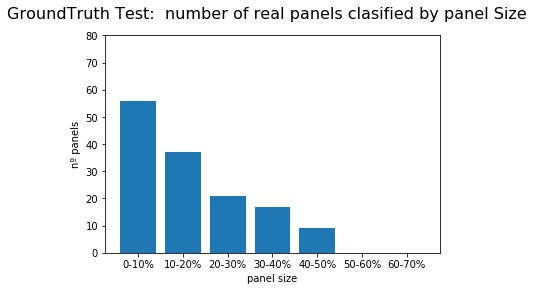

In [18]:
groundTruthSizeGraph('test_images/via_region_data.json', 'csv_reports/size_panels.csv')

### run inference over all test images

In [19]:
# map to save info of detections
predictedPrecisionMap = {}

# loop over each image to run inference
for j, image_path in enumerate(TEST_IMAGE_PATHS):

    # load image
    image = Image.open(image_path)
    image_np = load_image_into_numpy_array(image)
    image_np_expanded = np.expand_dims(image_np, axis=0)

    # run inference
    output_dict = run_inference_for_single_image(image_np, detection_graph)
    
    # print inference result over image
    vis_util.visualize_boxes_and_labels_on_image_array(image_np,
                                                       output_dict['detection_boxes'],
                                                       output_dict['detection_classes'],
                                                       output_dict['detection_scores'],
                                                       category_index,
                                                       instance_masks=output_dict.get('detection_masks'),
                                                       use_normalized_coordinates=True,
                                                       line_thickness=8)


    # get image size (w,h)
    width, height = image.size

    # get groundtruth image bounding boxes
    boxesTruth = boundingBoxGroundTruth('test_images/via_region_data.json', image_path.split('/')[1])

    # create a new section in the precision map
    # for actual imagen and fill info
    predictedPrecisionMap[image_path] = {
                                          'imagesize': width * height,
                                          'height_width': (height, width),
                                          'panelsOnImage': len(boxesTruth),
                                          'boxes': {}
                                        }

    # for each net detection over image
    for i, box in enumerate(output_dict['detection_boxes']):

        # if confidence is greater than 0.5
        if(output_dict['detection_scores'][i] > 0.5):

            # get normalize bounding box coordenates
            xmin, ymin = int(box[1] * width), int(box[0] * height)
            xmax, ymax = int(box[3] * width), int(box[2] * height)

            #  get the index of appropiate groundtruh bounding
            c1 = getCenterBox((xmin,ymin,xmax,ymax))
            dist = [distance.euclidean(c1, getCenterBox(bt)) for bt in boxesTruth]
            index = dist.index(min(dist))

            # calculate IoU value of actual detecction
            precision = bb_intersection_over_union(boxesTruth[index], (xmin,ymin,xmax,ymax))

            # print groundtruth bounding box in blue color
            xB, yB, xA, yA = boxesTruth[index]
            cv2.rectangle(image_np, (xB, yB), (xA, yA), (255,0,0), 4)

            # get size of groundtruth bounding box and predicted bounding box
            panelSize = abs(xB - xA) * abs(yB - yA)
            predictPanelSize = abs(xmax - xmin) * abs(ymax - ymin)

            # save prediction info into the map
            idx = len(predictedPrecisionMap[image_path]['boxes'])

            predictedPrecisionMap[image_path]['boxes'][idx] = {
                                                                'IoU':precision,
                                                                'panelSize':pannelPercentageOccupacy(width * height, panelSize),
                                                                'predictPanelSize' : pannelPercentageOccupacy(width * height, predictPanelSize),
                                                                'prediction':[(xmax, ymax), (xmin, ymin)]
                                                              }

    # save image with printed detections into disk
    cv2.imwrite("test_result/image"+str(j)+".jpg", image_np)

    
# save predictions info into the disk
with open('test_result/reports/result.json', 'w') as fp:
    json.dump(predictedPrecisionMap, fp)


### create graphs and reports 

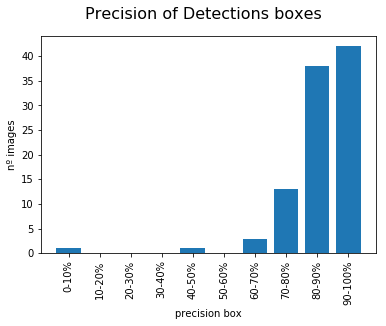

In [20]:
# create graph with precision info
predictionsHistogram(predictedPrecisionMap, 'csv_reports/percentage_panels.csv') 

/home/angel/.virtualenvs/cv/lib/python3.5/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


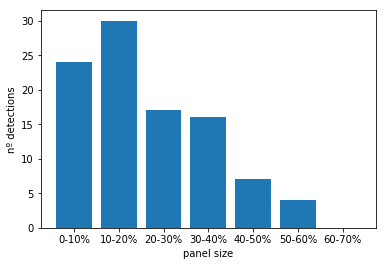

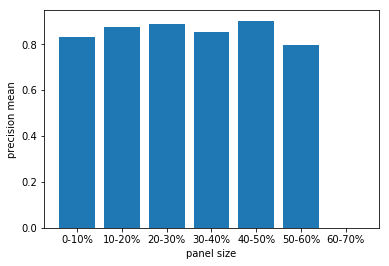

In [21]:
# create graphs and report for detections info
percentagePanelSizeVsTotal(predictedPrecisionMap, 'csv_reports/size_panels_mean.csv')

In [22]:
# create csv report with separate image detections information
createCsvSeparatedData(predictedPrecisionMap, 'csv_reports/separated_report.csv')